# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

Data was collected from a Portuguese bank that used human agents to contact targeted clients via telephone. These were collected as part of 17 integrated campaigns between May 2008 and November 2010 for a total of 79354 contacts. As part of the campaign an attractive long-term deposit application, with good interest rates, was offered. The target variable was the success of the contact. The campaign resulted in 6499 successes equivalent to an 8% success rate.

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [76]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, accuracy_score, precision_score, recall_score, plot_confusion_matrix, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.svm import SVC

In [2]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [3]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



##### Step 1 - Identify any missing values

In [4]:
df.isnull().sum().sort_values()

age               0
euribor3m         0
cons.conf.idx     0
cons.price.idx    0
emp.var.rate      0
poutcome          0
previous          0
pdays             0
campaign          0
nr.employed       0
duration          0
month             0
contact           0
loan              0
housing           0
default           0
education         0
marital           0
job               0
day_of_week       0
y                 0
dtype: int64

##### Step 2 - Explore each variable

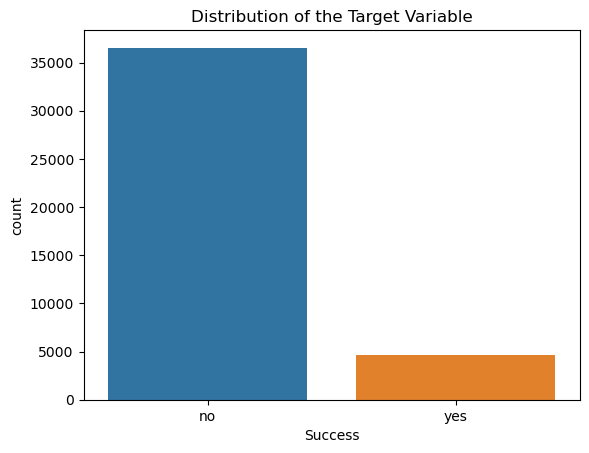

In [251]:
# Target Variable 'y'
sns.countplot(df['y'])
plt.title('Distribution of the Target Variable')
plt.xlabel('Success')
plt.savefig('images\success');
# Note that classes are highly imbalanced

In [6]:
# age, type integer
df['age'].describe()

count    41188.00000
mean        40.02406
std         10.42125
min         17.00000
25%         32.00000
50%         38.00000
75%         47.00000
max         98.00000
Name: age, dtype: float64

In [7]:
# job, type object
df['job'].value_counts()

admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64

In [8]:
# marital, type object
df['marital'].value_counts()

married     24928
single      11568
divorced     4612
unknown        80
Name: marital, dtype: int64

In [9]:
# education, type object
df['education'].value_counts()

university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: education, dtype: int64

In [10]:
# default, type object
df['default'].value_counts()

no         32588
unknown     8597
yes            3
Name: default, dtype: int64

In [11]:
# housing, type object
df['housing'].value_counts()

yes        21576
no         18622
unknown      990
Name: housing, dtype: int64

In [12]:
# loan, type object
df['loan'].value_counts()

no         33950
yes         6248
unknown      990
Name: loan, dtype: int64

In [13]:
# contact, type object
df['contact'].value_counts()

cellular     26144
telephone    15044
Name: contact, dtype: int64

In [14]:
# month, type object
df['month'].value_counts()

may    13769
jul     7174
aug     6178
jun     5318
nov     4101
apr     2632
oct      718
sep      570
mar      546
dec      182
Name: month, dtype: int64

In [15]:
# day_of_week, type object
df['day_of_week'].value_counts()

thu    8623
mon    8514
wed    8134
tue    8090
fri    7827
Name: day_of_week, dtype: int64

In [16]:
# duration, type integer, discard per notes, not appropriate for predictive models
df['duration'].describe()

count    41188.000000
mean       258.285010
std        259.279249
min          0.000000
25%        102.000000
50%        180.000000
75%        319.000000
max       4918.000000
Name: duration, dtype: float64

In [17]:
# campaign, type integer
df['campaign'].describe()

count    41188.000000
mean         2.567593
std          2.770014
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         56.000000
Name: campaign, dtype: float64

In [18]:
# pdays, type integer
df['pdays'].describe()

count    41188.000000
mean       962.475454
std        186.910907
min          0.000000
25%        999.000000
50%        999.000000
75%        999.000000
max        999.000000
Name: pdays, dtype: float64

<AxesSubplot:xlabel='pdays', ylabel='Count'>

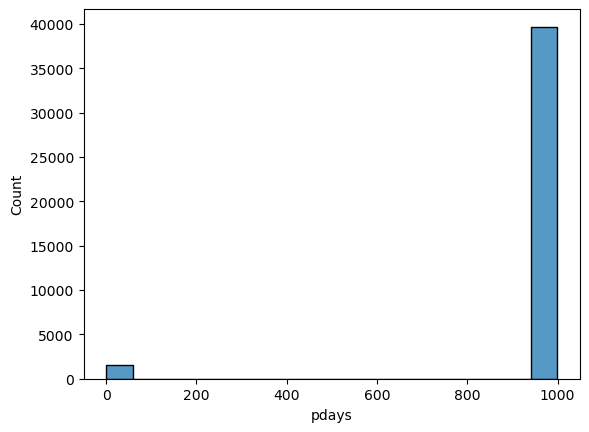

In [19]:
sns.histplot(df['pdays'])

In [20]:
# previous, type integer
df['previous'].describe()

count    41188.000000
mean         0.172963
std          0.494901
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          7.000000
Name: previous, dtype: float64

In [21]:
# poutcome, type object
df['poutcome'].value_counts()

nonexistent    35563
failure         4252
success         1373
Name: poutcome, dtype: int64

In [22]:
# emp.var.rate, type float
df['emp.var.rate'].describe()

count    41188.000000
mean         0.081886
std          1.570960
min         -3.400000
25%         -1.800000
50%          1.100000
75%          1.400000
max          1.400000
Name: emp.var.rate, dtype: float64

In [23]:
# cons.price.idx, type float
df['cons.price.idx'].describe()

count    41188.000000
mean        93.575664
std          0.578840
min         92.201000
25%         93.075000
50%         93.749000
75%         93.994000
max         94.767000
Name: cons.price.idx, dtype: float64

In [24]:
# cons.conf.idx, type float
df['cons.conf.idx'].describe()

count    41188.000000
mean       -40.502600
std          4.628198
min        -50.800000
25%        -42.700000
50%        -41.800000
75%        -36.400000
max        -26.900000
Name: cons.conf.idx, dtype: float64

In [25]:
# euribor3m, type float
df['euribor3m'].describe()

count    41188.000000
mean         3.621291
std          1.734447
min          0.634000
25%          1.344000
50%          4.857000
75%          4.961000
max          5.045000
Name: euribor3m, dtype: float64

In [26]:
# nr.employed, type float
df['nr.employed'].describe()

count    41188.000000
mean      5167.035911
std         72.251528
min       4963.600000
25%       5099.100000
50%       5191.000000
75%       5228.100000
max       5228.100000
Name: nr.employed, dtype: float64

#### Goals for Data Preparation
* Remove 'duration', per notes this column is not appropriate for predictive models
* Remove 'pdays', previous contact is incorporated into 'previous' column
* Convert categorical columns into dummy variables
* Scale numerical columns

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

The business goal is to develop a model that can identify the factors that determine whether a marketing contact will be successful, i.e. that a client will subscribe the deposit.

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features (columns 1 - 7), prepare the features and target column for modeling with appropriate encoding and transformations.

In [252]:
# Select the first 7 feature columns
X = df.iloc[:,0:7]
X.shape

(41188, 7)

In [253]:
# Select the target variable
y = df['y']

In [254]:
# Make a column transformer
# Scale the numeric column
# Convert oject columns to a numeric value
selector = make_column_selector(dtype_include=object)    # Select the object categories
transformer = make_column_transformer((OneHotEncoder(),selector), remainder=StandardScaler())

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [255]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42, stratify=y)

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

Create a zero rate classifier that always classifies to the largest class, in other words predicts to the most frequent class.

In [256]:
y_test.value_counts(normalize=True)

no     0.887346
yes    0.112654
Name: y, dtype: float64

If we predict all values are 'no', then we have an 88.7% chance of predicting correctly.

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [257]:
import time
start = time.time()
lr_pipe = Pipeline([
    ('transform', transformer),
    ('lr', LogisticRegression(max_iter = 10000, random_state=42))
]).fit(X_train,y_train)
end = time.time()

### Problem 9: Score the Model

What is the accuracy of your model?

In [277]:
lr_train_acc = lr_pipe.score(X_train,y_train)
lr_test_acc = lr_pipe.score(X_test,y_test)
lr_test_pre = precision_score(y_test, lr_pipe.predict(X_test), pos_label='yes')
lr_test_rec = recall_score(y_test, lr_pipe.predict(X_test), pos_label='yes')
lr_time = end-start
print(lr_train_acc,lr_test_acc, lr_test_pre, lr_test_rec, lr_time)

0.8873458288821987 0.8873458288821987 0.0 0.0 115.35629534721375


### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

Use KNN to build a basic model on the data.

In [261]:
start = time.time()
knn_pipe = Pipeline([
    ('transform', transformer),
    ('knn', KNeighborsClassifier())
]).fit(X_train,y_train)
end = time.time()

In [276]:
knn_train_acc = knn_pipe.score(X_train,y_train)
knn_test_acc = knn_pipe.score(X_test,y_test)
knn_test_pre = precision_score(y_test, knn_pipe.predict(X_test), pos_label='yes')
knn_test_rec = recall_score(y_test, knn_pipe.predict(X_test), pos_label='yes')
knn_time = end-start
print(knn_train_acc,knn_test_acc, knn_test_pre, knn_test_rec, knn_time)

0.8910685960312065 0.8772457997474993 0.3115942028985507 0.07413793103448275 115.35629534721375


Create a decision tree model.

In [263]:
start = time.time()
dt_pipe = Pipeline([
    ('transform', transformer),
    ('dt', DecisionTreeClassifier())
]).fit(X_train,y_train)
end = time.time()

In [278]:
dt_train_acc = dt_pipe.score(X_train,y_train)
dt_test_acc = dt_pipe.score(X_test,y_test)
dt_test_pre = precision_score(y_test, dt_pipe.predict(X_test), pos_label='yes')
dt_test_rec = recall_score(y_test, dt_pipe.predict(X_test), pos_label='yes')
dt_time = end-start
print(dt_train_acc,dt_test_acc,dt_test_pre, dt_test_rec, dt_time)

0.9177754038393059 0.8660774983004759 0.23990498812351543 0.08706896551724137 115.35629534721375


Create a support vector machine

In [265]:
start = time.time()
svc_pipe = Pipeline([
    ('transform', transformer),
    ('svc', SVC())
]).fit(X_train,y_train)
end = time.time()

In [279]:
svc_train_acc = svc_pipe.score(X_train,y_train)
svc_test_acc = svc_pipe.score(X_test,y_test)
svc_test_pre = precision_score(y_test, svc_pipe.predict(X_test), pos_label='yes')
svc_test_rec = recall_score(y_test, svc_pipe.predict(X_test), pos_label='yes')
svc_time = end-start
print(svc_train_acc,svc_test_acc,svc_test_pre, svc_test_rec, svc_time)

0.8880903823120002 0.8864717878993882 0.3333333333333333 0.007758620689655172 115.35629534721375


Compile results.

In [281]:
Model=['Logistic Regression','K-Nearest Neighbors','Decision Tree','Support Vector Machine']
Time = [lr_time,knn_time,dt_time,svc_time]
Train = [lr_train_acc,knn_train_acc,dt_train_acc,svc_train_acc]
Test = [lr_test_acc,knn_test_acc,dt_test_acc,svc_test_acc]
Prec = [lr_test_pre,knn_test_pre,dt_test_pre,svc_test_pre]
Rec = [lr_test_rec,knn_test_rec,dt_test_rec,svc_test_rec]
Results = pd.DataFrame({'Model':Model,'Train Accuracy':Train,'Test Accuracy':Test, 'Test Precision':Prec, 'Test Recall':Rec})
Results.set_index('Model')

,Train Accuracy,Test Accuracy,Test Precision,Test Recall
Model,,,,
Logistic Regression,0.887346,0.887346,0.000000,0.000000
K-Nearest Neighbors,0.891069,0.877246,0.311594,0.074138
Decision Tree,0.917775,0.866077,0.239905,0.087069
Support Vector Machine,0.888090,0.886472,0.333333,0.007759


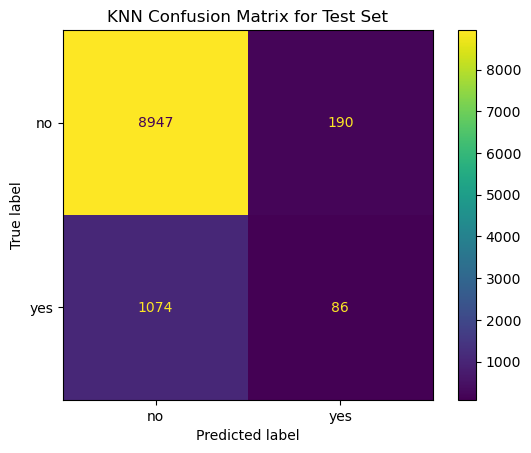

<Figure size 640x480 with 0 Axes>

In [273]:
# Create a KNN confusion matrix
knn_confusion_mat  = confusion_matrix(y_test, knn_pipe.predict(X_test), labels=knn_pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=knn_confusion_mat ,display_labels = ['no', 'yes'])
disp.plot()
plt.title('KNN Confusion Matrix for Test Set')
plt.show()
plt.savefig('images\knnCM')

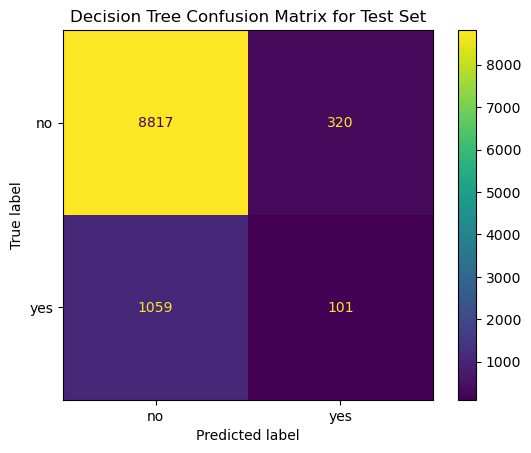

<Figure size 640x480 with 0 Axes>

In [274]:
# Create a DT confusion matrix
dt_confusion_mat  = confusion_matrix(y_test, dt_pipe.predict(X_test), labels=dt_pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=dt_confusion_mat ,display_labels = ['no', 'yes'])
disp.plot()
plt.title('Decision Tree Confusion Matrix for Test Set')
plt.show()
plt.savefig('images\dtCM')

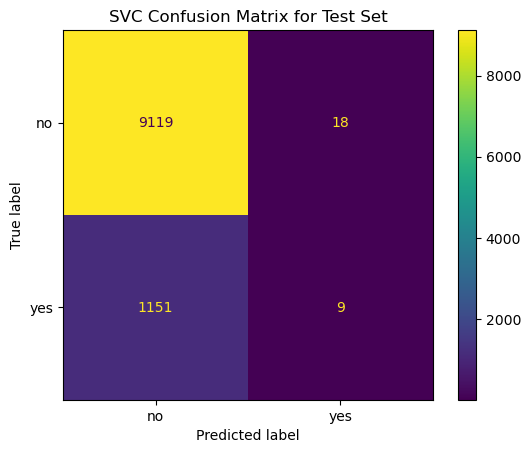

<Figure size 640x480 with 0 Axes>

In [275]:
# Create a SVC confusion matrix
svc_confusion_mat  = confusion_matrix(y_test, svc_pipe.predict(X_test), labels=svc_pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=svc_confusion_mat ,display_labels = ['no', 'yes'])
disp.plot()
plt.title('SVC Confusion Matrix for Test Set')
plt.show()
plt.savefig('images\svcCM')

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

##### Feature engineering and exploration

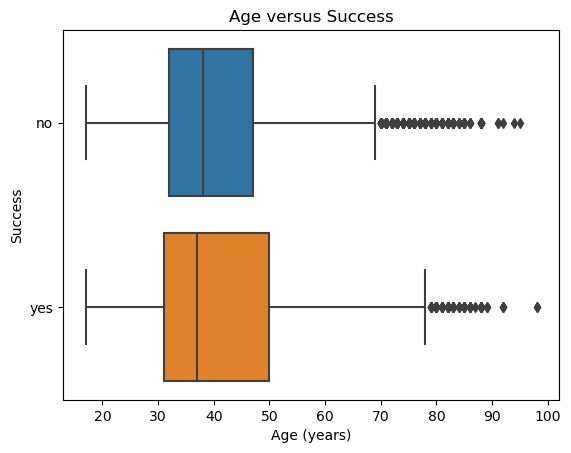

In [141]:
# plot age versus success
sns.boxplot(data= df, x='age', y='y')
plt.title('Age versus Success')
plt.ylabel('Success')
plt.xlabel('Age (years)')
plt.savefig('images\age_success');

There is no distinction by age, remove age from the model.

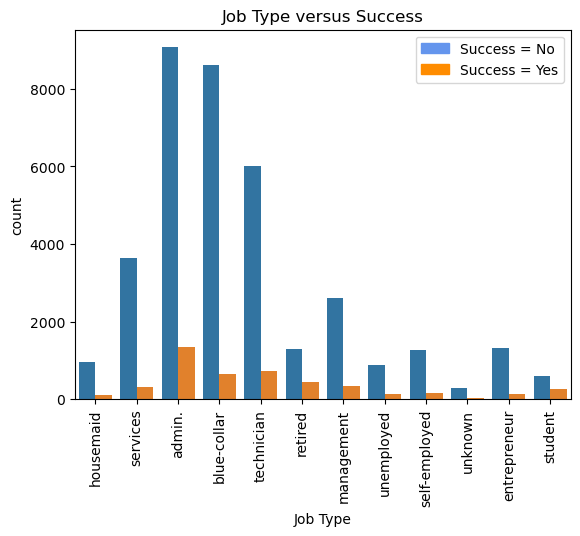

In [213]:
# Plot job versus success
sns.countplot(data=df, x ='job', hue='y')
plt.xticks(rotation=90)
top_bar = mpatches.Patch(color='cornflowerblue', label='Success = No')
bottom_bar = mpatches.Patch(color='darkorange', label='Success = Yes')
plt.legend(handles = [top_bar,bottom_bar])
plt.title('Job Type versus Success')
plt.xlabel('Job Type')
plt.savefig('images\job.png', format='png', bbox_inches='tight');

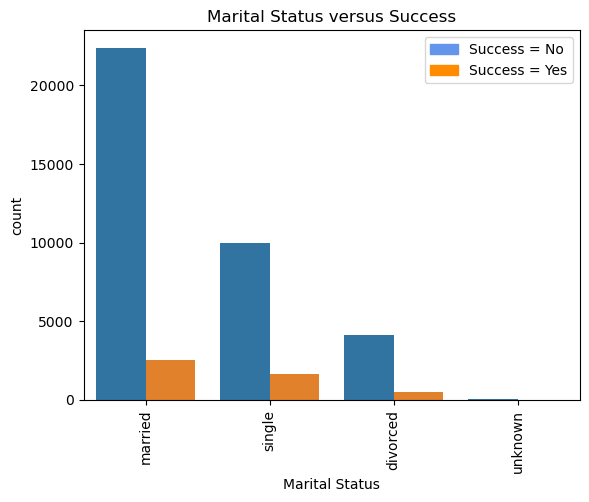

In [214]:
# plot marital status versus success
sns.countplot(data=df, x ='marital', hue='y')
plt.xticks(rotation=90)
top_bar = mpatches.Patch(color='cornflowerblue', label='Success = No')
bottom_bar = mpatches.Patch(color='darkorange', label='Success = Yes')
plt.legend(handles = [top_bar,bottom_bar])
plt.title('Marital Status versus Success')
plt.xlabel('Marital Status')
plt.savefig('images\marital.png', format='png', bbox_inches='tight');

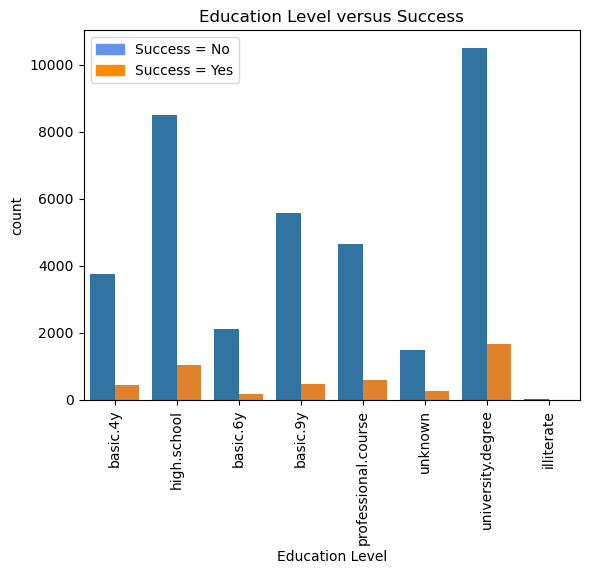

In [215]:
# plot education versus success
sns.countplot(data=df, x ='education', hue='y')
plt.xticks(rotation=90)
top_bar = mpatches.Patch(color='cornflowerblue', label='Success = No')
bottom_bar = mpatches.Patch(color='darkorange', label='Success = Yes')
plt.legend(handles = [top_bar,bottom_bar])
plt.title('Education Level versus Success')
plt.xlabel('Education Level')
plt.savefig('images\eduction.png', format='png', bbox_inches='tight');

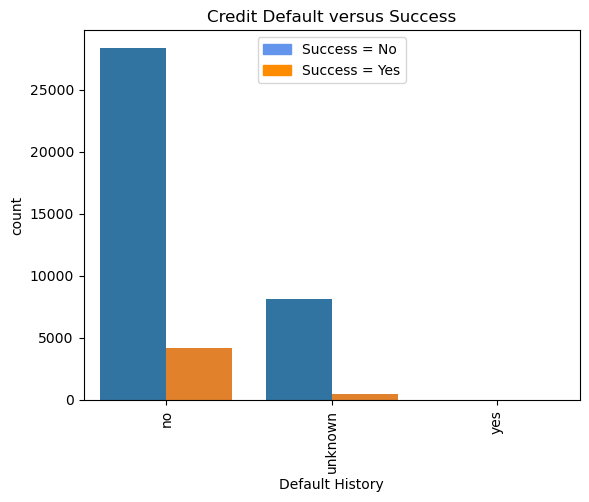

In [216]:
# plot credit default history versus success
sns.countplot(data=df, x ='default', hue='y')
plt.xticks(rotation=90)
top_bar = mpatches.Patch(color='cornflowerblue', label='Success = No')
bottom_bar = mpatches.Patch(color='darkorange', label='Success = Yes')
plt.legend(handles = [top_bar,bottom_bar])
plt.title('Credit Default versus Success')
plt.xlabel('Default History')
plt.savefig('images\default.png', format='png', bbox_inches='tight');

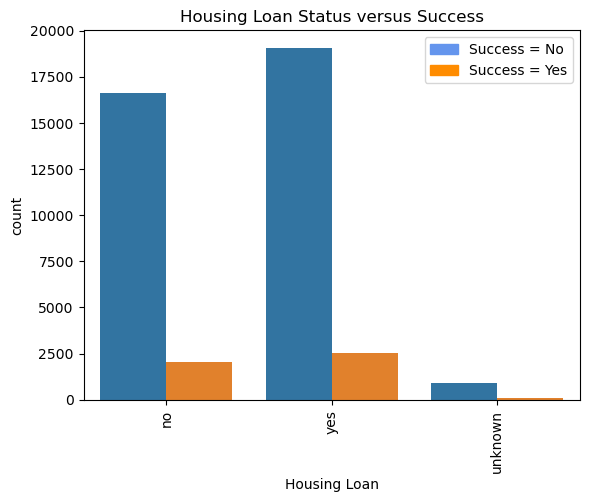

In [217]:
# plot housing loan versus success
sns.countplot(data=df, x ='housing', hue='y')
plt.xticks(rotation=90)
top_bar = mpatches.Patch(color='cornflowerblue', label='Success = No')
bottom_bar = mpatches.Patch(color='darkorange', label='Success = Yes')
plt.legend(handles = [top_bar,bottom_bar])
plt.title('Housing Loan Status versus Success')
plt.xlabel('Housing Loan')
plt.savefig('images\housing.png', format='png', bbox_inches='tight');

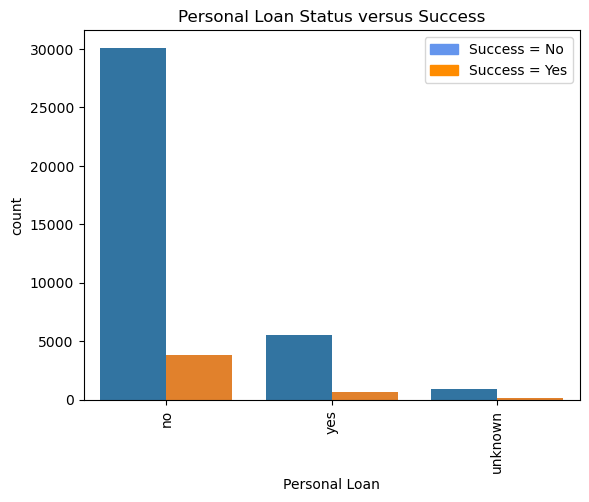

In [218]:
# plot personal loan status versus success
sns.countplot(data=df, x ='loan', hue='y')
plt.xticks(rotation=90)
top_bar = mpatches.Patch(color='cornflowerblue', label='Success = No')
bottom_bar = mpatches.Patch(color='darkorange', label='Success = Yes')
plt.legend(handles = [top_bar,bottom_bar])
plt.title('Personal Loan Status versus Success')
plt.xlabel('Personal Loan')
plt.savefig('images\loan.png', format='png', bbox_inches='tight');

Remove age, keep all other variables as is.

In [49]:
Xnew = X.drop(['age'], axis=1)
Xnew.head()

,job,marital,education,default,housing,loan
0,housemaid,married,basic.4y,no,no,no
1,services,married,high.school,unknown,no,no
2,services,married,high.school,no,yes,no
3,admin.,married,basic.6y,no,no,no
4,services,married,high.school,no,no,yes


In [52]:
# Create training and test data sets without age variable
X_train, X_test, y_train, y_test = train_test_split(Xnew,y,random_state=42, stratify=y)

##### Fine-tune KNN model
Find optimum k value

In [65]:
# Note we ran the search from k = 1 to 1000, but narrowed down to find the optimum k
knn_params = {'knn__n_neighbors':np.array(range(55,58,1))}

knn_pipe = Pipeline([
    ('transform', transformer),
    ('knn', KNeighborsClassifier())
])

In [66]:
import warnings
warnings.filterwarnings('ignore')
knn_grid = GridSearchCV(knn_pipe,param_grid = knn_params).fit(X_train,y_train)
knn_grid.best_params_

{'knn__n_neighbors': 56}

Set decision boundary

In [67]:
# first run model using n_neighbors = 56
knn_pipe = Pipeline([
    ('transform', transformer),
    ('knn', KNeighborsClassifier(n_neighbors=56))
]).fit(X_train,y_train)

In [71]:
# compare training metrics
knn_train_preds = knn_pipe.predict(X_train)
knn_acc = accuracy_score(y_train,knn_train_preds)
knn_pre = precision_score(y_train,knn_train_preds,pos_label='yes')
knn_rec = recall_score(y_train,knn_train_preds, pos_label='yes')
print(knn_acc, knn_pre, knn_rec)

0.8873458288821987 0.0 0.0


In [72]:
# compare test metrics
knn_test_preds = knn_pipe.predict(X_test)
knn_acc = accuracy_score(y_test,knn_test_preds)
knn_pre = precision_score(y_test,knn_test_preds,pos_label='yes')
knn_rec = recall_score(y_test,knn_test_preds, pos_label='yes')
print(knn_acc, knn_pre, knn_rec)

0.8873458288821987 0.0 0.0


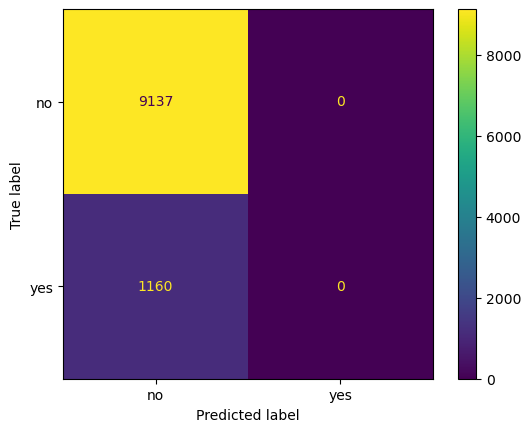

In [79]:
knn_confusion_mat  = confusion_matrix(y_test, knn_test_preds, labels=knn_pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=knn_confusion_mat ,display_labels = ['no', 'yes'])
disp.plot()
plt.show()

Based on the confusion matrix, the model is not trying to classify data. Try changing the decision threshold.

In [83]:
thresholds = np.arange(0, 1, .1)
thresholds

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [84]:
test_predictions = knn_pipe.predict_proba(X_test)
test_predictions[1:5]

array([[0.98214286, 0.01785714],
       [0.94642857, 0.05357143],
       [0.76785714, 0.23214286],
       [0.98214286, 0.01785714]])

In [89]:
def accuracy_thresh(predict_probs, 
                  y_test, 
                  thresh):
    preds = np.where(predict_probs >= thresh, 'yes', 'no')
    
    return accuracy_score(y_test, preds)
results_df = pd.DataFrame({'threshold': thresholds, 'accuracy': [accuracy_thresh(test_predictions[:, 1], y_test, i) for i in thresholds]})
results_df

,threshold,accuracy
0,0.0,0.112654
1,0.1,0.510149
2,0.2,0.832087
3,0.3,0.883073
4,0.4,0.887249
5,0.5,0.887346
6,0.6,0.887346
7,0.7,0.887346
8,0.8,0.887346
9,0.9,0.887346


Knn model is basically the baseline model

##### Fine-tune the logistic regression model

Select Features

In [283]:
extractor = SelectFromModel(LogisticRegression(penalty='l1',solver='liblinear',random_state=42))
lr_pipe = Pipeline([
    ('transform', transformer),
    ('extractor', extractor),
    ('lr', LogisticRegression(max_iter = 10000, random_state=42))
]).fit(X_train,y_train)
feature_names = lr_pipe.named_steps['transform'].get_feature_names_out() 
selected_features =feature_names[ [int(i[1:]) for i in lr_pipe.named_steps['extractor'].get_feature_names_out()]]
clean_names = [i.split('__')[-1] for i in selected_features]
clean_names

['job_admin.',
 'job_blue-collar',
 'job_entrepreneur',
 'job_management',
 'job_retired',
 'job_self-employed',
 'job_services',
 'job_student',
 'job_technician',
 'job_unemployed',
 'job_unknown',
 'marital_divorced',
 'marital_married',
 'marital_unknown',
 'education_basic.9y',
 'education_high.school',
 'education_illiterate',
 'education_professional.course',
 'education_university.degree',
 'education_unknown',
 'default_unknown',
 'housing_no',
 'housing_yes',
 'loan_yes',
 'age']

In [115]:
# Compare train metrics
lr_train_preds = lr_pipe.predict(X_train)
lr_test_preds = lr_pipe.predict(X_test)
lr_train_acc = accuracy_score(y_train,lr_train_preds)
lr_test_acc = accuracy_score(y_test,lr_test_preds)
print(lr_train_acc,lr_test_acc)

0.8873458288821987 0.8873458288821987


In [288]:
coef_df = pd.DataFrame({'feature': clean_names, 'coefs': lr_pipe.named_steps['lr'].coef_[0]})
#coef_df['coefs'] = coef_df['coefs'].apply(abs)
coef_df = coef_df.sort_values(by = 'coefs', ascending = False)
coef_df.set_index('feature')

,coefs
feature,
job_student,1.208258
job_retired,0.830773
education_illiterate,0.634629
job_unemployed,0.365216
job_unknown,0.226591
education_unknown,0.224526
marital_unknown,0.173354
education_university.degree,0.164753
age,0.143304


In [228]:
# Repeat using max features = 10
extractor = SelectFromModel(LogisticRegression(penalty='l1',solver='liblinear',random_state=42), max_features=5)
lr_pipe = Pipeline([
    ('transform', transformer),
    ('extractor', extractor),
    ('lr', LogisticRegression(max_iter = 10000, random_state=42))
]).fit(X_train,y_train)
feature_names = lr_pipe.named_steps['transform'].get_feature_names_out() 
selected_features =feature_names[ [int(i[1:]) for i in lr_pipe.named_steps['extractor'].get_feature_names_out()]]
clean_names = [i.split('__')[-1] for i in selected_features]
clean_names

['job_retired',
 'job_student',
 'job_unemployed',
 'education_illiterate',
 'default_unknown']

In [229]:
# Compare metrics
lr_train_preds = lr_pipe.predict(X_train)
lr_test_preds = lr_pipe.predict(X_test)
lr_train_acc = accuracy_score(y_train,lr_train_preds)
lr_test_acc = accuracy_score(y_test,lr_test_preds)
print(lr_train_acc,lr_test_acc)

0.8873458288821987 0.8873458288821987


In [110]:
coef_df = pd.DataFrame({'feature': clean_names, 'coefs': lr_pipe.named_steps['lr'].coef_[0]})
# coef_df['coefs'] = coef_df['coefs'].apply(abs)
coef_df = coef_df.sort_values(by = 'coefs', ascending = False)
coef_df

,feature,coefs
4,job_student,1.177236
2,job_retired,1.014404
8,education_illiterate,0.544220
5,job_unemployed,0.309981
6,marital_divorced,-0.189513
7,education_basic.9y,-0.264631
1,job_entrepreneur,-0.278865
3,job_services,-0.341287
0,job_blue-collar,-0.354937
9,default_unknown,-0.893229


##### Fine-Tune hyperparameters for decision tree

In [119]:
dt_pipe = Pipeline([
    ('transform', transformer),
    ('dt', DecisionTreeClassifier())
])
dt_params = {'dt__max_depth': ['None', 3,8,12]}

In [123]:
dt_grid = GridSearchCV(dt_pipe,param_grid=dt_params).fit(X_train,y_train)
dt_grid.cv_results_

{'mean_fit_time': array([0.09301448, 0.10196171, 0.16148853, 0.21711121]),
 'std_fit_time': array([0.00459212, 0.005464  , 0.01509426, 0.009879  ]),
 'mean_score_time': array([0.        , 0.0303287 , 0.03044605, 0.02640953]),
 'std_score_time': array([0.        , 0.00437691, 0.00270905, 0.00118162]),
 'param_dt__max_depth': masked_array(data=['None', 3, 8, 12],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'dt__max_depth': 'None'},
  {'dt__max_depth': 3},
  {'dt__max_depth': 8},
  {'dt__max_depth': 12}],
 'split0_test_score': array([       nan, 0.88736041, 0.88590387, 0.88558019]),
 'split1_test_score': array([       nan, 0.88734218, 0.88604726, 0.88507608]),
 'split2_test_score': array([       nan, 0.88734218, 0.8858854 , 0.88410489]),
 'split3_test_score': array([       nan, 0.88734218, 0.88750405, 0.88701845]),
 'split4_test_score': array([       nan, 0.88734218, 0.88572354, 0.88394302]),
 'mean_test_score': array([

In [121]:
dt_pipe = Pipeline([
    ('transform', transformer),
    ('dt', DecisionTreeClassifier(max_depth=3))
]).fit(X_train,y_train)
dt_pipe.score(X_train,y_train)

0.8873458288821987

In [127]:
dtree_text = export_text(dt_pipe.named_steps['dt'])
print(dtree_text)

|--- feature_24 <= 0.50
|   |--- feature_5 <= 0.50
|   |   |--- feature_17 <= 0.50
|   |   |   |--- class: no
|   |   |--- feature_17 >  0.50
|   |   |   |--- class: no
|   |--- feature_5 >  0.50
|   |   |--- feature_23 <= 0.50
|   |   |   |--- class: no
|   |   |--- feature_23 >  0.50
|   |   |   |--- class: no
|--- feature_24 >  0.50
|   |--- feature_5 <= 0.50
|   |   |--- feature_8 <= 0.50
|   |   |   |--- class: no
|   |   |--- feature_8 >  0.50
|   |   |   |--- class: no
|   |--- feature_5 >  0.50
|   |   |--- feature_16 <= 0.50
|   |   |   |--- class: no
|   |   |--- feature_16 >  0.50
|   |   |   |--- class: no



##### Search and remove duplicate observations

In [138]:
dfclean = df[['job','marital','education','default','housing','loan','y']]
dfclean = dfclean.drop_duplicates(subset=['job','marital','education','default','housing','loan'],keep='first')
dfclean.shape

(1726, 7)

In [140]:
dfclean['y'].value_counts(normalize=True)

no     0.940324
yes    0.059676
Name: y, dtype: float64

##### Tune hyperparameters for SVC and grid search.
commented out, run time was too long to proceed

In [ ]:
# params = {'svc__kernel': ['poly', 'linear', 'sigmoid'}

#svc_pipe = Pipeline([
#    ('transform', transformer),
#    ('svc', SVC())
#])

In [ ]:
#start = time.time()
#svc_grid = GridSearchCV(svc_pipe, param_grid=params).fit(X_train, y_train)
#end = time.time()

In [ ]:
#svc_grid.best_params_

### Generate descriptive statistics

In [142]:
import scipy.stats as stats

In [151]:
# Create a contingency table between 'job' feature and the success rate ('Y' column)
job_cont_table = pd.crosstab(dfclean['y'], dfclean['job'])

# Apply chi-square test on the contingeny table
job_chi = stats.chi2_contingency(job_cont_table)[0]

# Start compiling results into a data frame
data_list = [['job', job_chi]]

chi_table = pd.DataFrame(data_list, columns=['Column','Chi-Square'])

In [152]:
# Create a contingency table between 'marital' feature and the success rate ('Y' column)
marital_cont_table = pd.crosstab(dfclean['y'], dfclean['marital'])

# Apply chi-square test on the contingeny table
marital_chi = stats.chi2_contingency(marital_cont_table)[0]

# Start compiling results into a data frame
chi_table = chi_table.append({'Column':'marital', 'Chi-Square':marital_chi}, ignore_index=True)
chi_table

,Column,Chi-Square
0,job,22.383324
1,marital,8.012887


In [153]:
# Create a contingency table between 'education' feature and the success rate ('Y' column)
education_cont_table = pd.crosstab(dfclean['y'], dfclean['education'])

# Apply chi-square test on the contingeny table
education_chi = stats.chi2_contingency(education_cont_table)[0]

# Start compiling results into a data frame
chi_table = chi_table.append({'Column':'education', 'Chi-Square':education_chi}, ignore_index=True)
chi_table

,Column,Chi-Square
0,job,22.383324
1,marital,8.012887
2,education,23.732190


In [154]:
# Create a contingency table between 'default' feature and the success rate ('Y' column)
default_cont_table = pd.crosstab(dfclean['y'], dfclean['default'])

# Apply chi-square test on the contingeny table
default_chi = stats.chi2_contingency(default_cont_table)[0]

# Start compiling results into a data frame
chi_table = chi_table.append({'Column':'default', 'Chi-Square':default_chi}, ignore_index=True)
chi_table

,Column,Chi-Square
0,job,22.383324
1,marital,8.012887
2,education,23.732190
3,default,3.225474


In [155]:
# Create a contingency table between 'housing' feature and the success rate ('Y' column)
housing_cont_table = pd.crosstab(dfclean['y'], dfclean['housing'])

# Apply chi-square test on the contingeny table
housing_chi = stats.chi2_contingency(housing_cont_table)[0]

# Start compiling results into a data frame
chi_table = chi_table.append({'Column':'housing', 'Chi-Square':housing_chi}, ignore_index=True)
chi_table

,Column,Chi-Square
0,job,22.383324
1,marital,8.012887
2,education,23.732190
3,default,3.225474
4,housing,2.463106


In [156]:
# Create a contingency table between 'loan' feature and the success rate ('Y' column)
loan_cont_table = pd.crosstab(dfclean['y'], dfclean['loan'])

# Apply chi-square test on the contingeny table
loan_chi = stats.chi2_contingency(loan_cont_table)[0]

# Start compiling results into a data frame
chi_table = chi_table.append({'Column':'loan', 'Chi-Square':loan_chi}, ignore_index=True)
chi_table.set_index('Column')

,Chi-Square
Column,
job,22.383324
marital,8.012887
education,23.732190
default,3.225474
housing,2.463106
loan,0.194872


In [171]:
# Create a table showing percentage of jobs by success
job_cont_table

job,admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed,unknown
y,,,,,,,,,,,,
no,170,195,124,133,126,137,133,167,65,169,124,80
yes,8,8,9,8,9,12,4,12,12,6,7,8


In [223]:
column =['admin', 'blue-collar', 'entrepreneur', 'housemaid', 'management', 'retired', 'self-employed', 'services', 'student', 'technician', 'unemployed', 'unknown']
percent = [8/(170+8), 8/(195+8), 9/(124+9), 8/(133+8), 9/(126+9), 12/(137+12), 
          4/(133+4), 12/(167+12), 12/(65+12), 6/(169+6), 7/(124+7), 8/(80+8)]
job_df = pd.DataFrame({'Category':column, 'Percent Success':percent})
job_df['Percent Success']=round(job_df['Percent Success']*100,2)
job_df.set_index('Category')

,Percent Success
Category,
admin,4.49
blue-collar,3.94
entrepreneur,6.77
housemaid,5.67
management,6.67
retired,8.05
self-employed,2.92
services,6.70
student,15.58


In [186]:
# Create a table showing percent sucess by marital status
marital_cont_table

marital,divorced,married,single,unknown
y,,,,
no,405,670,499,49
yes,27,30,40,6


In [224]:
column =['divorced', 'married', 'single', 'unknown']
percent = [27/(405+27), 30/(670+30), 40/(499+40), 6/(49+6)]
marital_df = pd.DataFrame({'Category':column, 'Percent Success':percent})
marital_df['Percent Success']=round(marital_df['Percent Success']*100,2)
marital_df.set_index('Category')

,Percent Success
Category,
divorced,6.25
married,4.29
single,7.42
unknown,10.91


In [190]:
# Create a table showing percent sucess by education level
education_cont_table

education,basic.4y,basic.6y,basic.9y,high.school,illiterate,professional.course,university.degree,unknown
y,,,,,,,,
no,217,188,236,268,10,231,273,200
yes,8,14,16,12,3,9,16,25


In [225]:
column = ['basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'illiterate', 'professional.course', 'university.degree', 'unknown']
percent = [8/(217+8), 14/(188+14), 16/(236+16), 12/(268+12), 3/(10+3), 9/(231+9), 16/(273+16), 25/(225)]
education_df = pd.DataFrame({'Category':column, 'Percent Success':percent})
education_df['Percent Success']=round(education_df['Percent Success']*100,2)
education_df.set_index('Category')

,Percent Success
Category,
basic.4y,3.56
basic.6y,6.93
basic.9y,6.35
high.school,4.29
illiterate,23.08
professional.course,3.75
university.degree,5.54
unknown,11.11


In [199]:
# Create a table showing percent sucess by credit default
default_cont_table

default,no,unknown,yes
y,,,
no,928,692,3
yes,68,35,0


In [200]:
column = ['no', 'unknown', 'yes']
percent = [68/(928+68), 35/(692+35), 0/(3)]
default_df = pd.DataFrame({'Category':column, 'Percent Success':percent})
default_df['Percent Success']=round(default_df['Percent Success']*100,2)
default_df.set_index('Category')

,Percent Success
Category,
no,6.83
unknown,4.81
yes,0.00


In [219]:
# Create a table showing percent sucess by housing loan status
housing_cont_table

housing,no,unknown,yes
y,,,
no,708,196,719
yes,37,13,53


In [220]:
column = ['no', 'unknown', 'yes']
percent = [37/(708+37), 13/(196+13), 53/(719+53)]
housing_df = pd.DataFrame({'Category':column, 'Percent Success':percent})
housing_df['Percent Success']=round(housing_df['Percent Success']*100,2)
housing_df.set_index('Category')

,Percent Success
Category,
no,4.97
unknown,6.22
yes,6.87


In [221]:
# Create a table showing percent sucess by personal loan status
loan_cont_table

loan,no,unknown,yes
y,,,
no,840,196,587
yes,51,13,39


In [222]:
column = ['no', 'unknown', 'yes']
percent = [51/(840+51), 13/(196+13), 39/(587+39)]
loan_df = pd.DataFrame({'Category':column, 'Percent Success':percent})
loan_df['Percent Success']=round(loan_df['Percent Success']*100,2)
loan_df.set_index('Category')

,Percent Success
Category,
no,5.72
unknown,6.22
yes,6.23


##### Try univariate and bivariate model

In [248]:
X_one = X[['education', 'job']]
X_1train,X_1test, y_train, y_test = train_test_split(X_one,y,random_state=42, stratify=y)

In [242]:
extractor = SelectFromModel(LogisticRegression(penalty='l1',solver='liblinear',random_state=42))
lr_pipe = Pipeline([
    ('transform', transformer),
    ('extractor', extractor),
    ('lr', LogisticRegression(max_iter = 10000, random_state=42))
]).fit(X_1train,y_train)

In [243]:
lr_train_preds = lr_pipe.predict(X_1train)
lr_test_preds = lr_pipe.predict(X_1test)
lr_train_acc = accuracy_score(y_train,lr_train_preds)
lr_test_acc = accuracy_score(y_test,lr_test_preds)
print(lr_train_acc,lr_test_acc)

0.8873458288821987 0.8873458288821987


In [249]:
dt_grid = GridSearchCV(dt_pipe,param_grid=dt_params).fit(X_1train,y_train)
dt_grid.cv_results_

{'mean_fit_time': array([0.07511096, 0.09372749, 0.10262399, 0.09060378]),
 'std_fit_time': array([0.01808969, 0.00987933, 0.01612319, 0.01168854]),
 'mean_score_time': array([0.        , 0.02772384, 0.02698092, 0.0281178 ]),
 'std_score_time': array([0.        , 0.01106641, 0.00739808, 0.0062495 ]),
 'param_dt__max_depth': masked_array(data=['None', 3, 8, 12],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'dt__max_depth': 'None'},
  {'dt__max_depth': 3},
  {'dt__max_depth': 8},
  {'dt__max_depth': 12}],
 'split0_test_score': array([       nan, 0.88736041, 0.8868749 , 0.88671306]),
 'split1_test_score': array([       nan, 0.88734218, 0.88734218, 0.88734218]),
 'split2_test_score': array([       nan, 0.88734218, 0.88718032, 0.88718032]),
 'split3_test_score': array([       nan, 0.88734218, 0.88734218, 0.88734218]),
 'split4_test_score': array([       nan, 0.88734218, 0.88669472, 0.88637099]),
 'mean_test_score': array([